In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from scipy import stats

In [2]:
def multivariateGausssian(X, mu, sigma):
    '''
    X:(m, n)
    '''
    m, n = X.shape
    if(np.ndim(sigma)==1):
        sigma = np.diag(sigma)
    left = 1.0 / (np.power(2 * np.pi, n/2) * np.sqrt(np.linalg.det(sigma)))
    right = np.zeros((m, 1))
    for row in range(m):
        x = X[row]
        right[row] = np.exp(-0.5 * (x-mu).T @ np.linalg.inv(sigma) @ (x-mu))
    return left*right

In [3]:
def estimateGaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    return mu, sigma

In [4]:
def selectThreshold(pval, yval):
    best_e, best_f1, f1 = 0, 0, 0
    step = (pval.max() - pval.min()) / 1000
    for e in np.arange(pval.min(), pval.max(), step):
        preds = pval < e
        tp = np.sum(np.logical_and(preds==1, yval==1))
        fp = np.sum(np.logical_and(preds==1, yval==0))
        fn = np.sum(np.logical_and(preds==0, yval==1))
        tn = np.sum(np.logical_and(preds==0, yval==0))
        precision = tp / (tp + fp)
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        if(f1 > best_f1):
            best_f1 = f1
            best_e = e
    return best_e, best_f1

def selectThreshold_by_accuracy(pval, yval):
    best_e, best_accu, f1 = 0, 0, 0
    step = (pval.max() - pval.min()) / 1000
    for e in np.arange(pval.min(), pval.max(), step):
        preds = pval < e
        tp = np.sum(np.logical_and(preds==1, yval==1))
        fp = np.sum(np.logical_and(preds==1, yval==0))
        fn = np.sum(np.logical_and(preds==0, yval==1))
        tn = np.sum(np.logical_and(preds==0, yval==0))
        precision = tp / (tp + fp)
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        if(accuracy > best_accu):
            best_accu = accuracy
            best_e = e
    return best_e, best_accu

def selectThreshold_by_truepositive(pval, yval):
    best_e, best_tpr, f1 = 0, 0, 0
    step = (pval.max() - pval.min()) / 1000
    for e in np.arange(pval.min(), pval.max(), step):
        preds = pval < e
        tp = np.sum(np.logical_and(preds==1, yval==1))
        fp = np.sum(np.logical_and(preds==1, yval==0))
        fn = np.sum(np.logical_and(preds==0, yval==1))
        tn = np.sum(np.logical_and(preds==0, yval==0))
        tpr = tp / (tp + fn)
        if(tpr > best_tpr):
            best_tpr = tpr
            best_e = e
    return best_e, best_tpr

In [5]:
df = pd.read_csv("../data/repa_data_20231109.csv")

df.columns

Index(['is_retracted', 'published_time', 'total_comment', 'author_active',
       'comment_len', 'reword', 'squ_published_time', 'squ_total_comment',
       'squ_author_active', 'squ_comment_len', 'squ_reword',
       'sqrt_published_time', 'sqrt_total_comment', 'sqrt_author_active',
       'sqrt_comment_len', 'sqrt_reword'],
      dtype='object')

In [6]:
from sklearn.preprocessing import StandardScaler
X = df.drop("is_retracted", axis=1)

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
import random
random.seed(622)
y = df["is_retracted"]
re_idx = y == "Yes"
re_X = X[re_idx]
re_Y = y[re_idx]
nre_X = X[~re_idx]
nre_Y = y[~re_idx]
re_Y = re_Y.reset_index(drop=True)
nre_Y = nre_Y.reset_index(drop=True)

In [9]:
test_re_idx = random.sample(range(re_X.shape[0]), k=1000)
test_nre_idx = random.sample(range(nre_X.shape[0]), k=1000)

test_re_X = re_X[test_re_idx]
test_re_Y = re_Y[test_re_idx]
train_re_X = np.delete(re_X, test_re_idx, axis=0)
train_re_Y = re_Y.drop(test_re_idx)
test_nre_X = nre_X[test_nre_idx]
test_nre_Y = nre_Y[test_nre_idx]
train_nre_X = np.delete(nre_X, test_nre_idx, axis=0)
train_nre_Y = nre_Y.drop(test_nre_idx)

In [10]:
test_data_X = np.vstack((test_re_X, test_nre_X))
test_data_Y = pd.concat([test_re_Y, test_nre_Y])
train_data_X = np.vstack((train_re_X, train_nre_X))
train_data_Y = pd.concat([train_re_Y, train_nre_Y])

In [11]:
mu, sigma2 = estimateGaussian(train_data_X)

In [12]:
pval = multivariateGausssian(test_data_X, mu, sigma2)
test_data_Y.replace({"Yes": 1, "No": 0}, inplace=True)
e3, tfr = selectThreshold_by_truepositive(pval.flatten(), test_data_Y)
print(e3, tfr)

9.204008901544762e-07 0.9995


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
def draw_roc(pval, yval):
    tpr_list = []
    fpr_list = []
    step = (pval.max() - pval.min()) / 1000
    for e in np.arange(pval.min(), pval.max(), step):
        preds = pval < e
        # print(preds)
        tp = np.sum(np.logical_and(preds==True, yval==1))
        fp = np.sum(np.logical_and(preds==True, yval==0))
        fn = np.sum(np.logical_and(preds==False, yval==1))
        tn = np.sum(np.logical_and(preds==False, yval==0))
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        # print(tp, fp, fn, tn)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    sns.set_theme()
    plt.rcParams['font.sans-serif'] = ['STSong']
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_list, tpr_list, color='darkorange', lw=2, label=f'ROC曲线')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假阳性率')
    plt.ylabel('真阳性率')
    plt.title('逻辑斯蒂回归分类结果的ROC曲线')
    plt.legend(loc='lower right')
    plt.show()

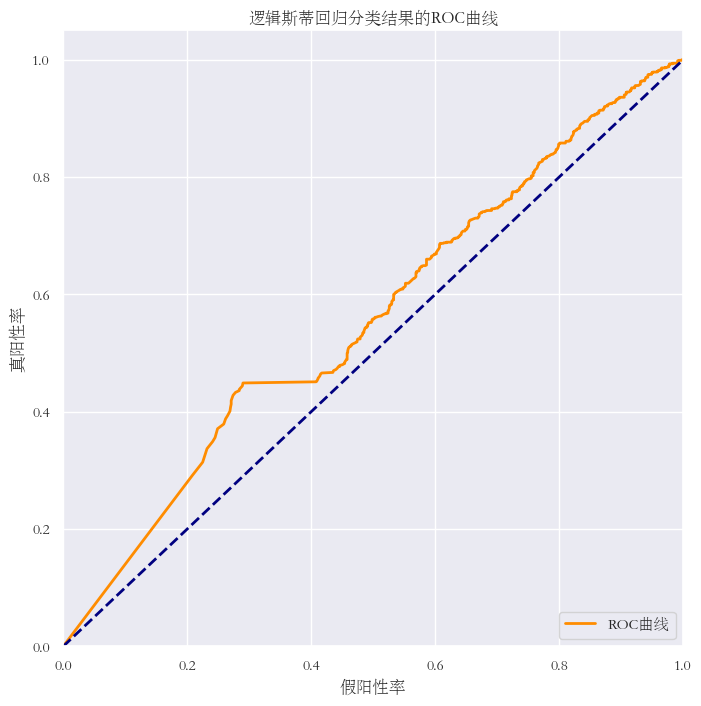

In [20]:
draw_roc(pval.flatten(), test_data_Y.to_numpy())

In [21]:
e3, tfr = selectThreshold_by_truepositive(pval.flatten(), test_data_Y)